## ARHMM Example Notebook
### Overview
This notebook illustrates how to use `jax_moseq.models.arhmm` to fit a sticky hierarchical Dirichlet process autoregressive hidden Markov model (henceforth simply an "ARHMM") to time series data via Gibbs sampling. Building on earlier work by Fox et al. (2008), in the original MoSeq paper, Wiltchsko et al. (2015) used this model to show that mouse behavior consists of concatenated sequences of discrete action patterns called syllables. Here we recapitulate that analysis to demo our `jax` implementation of the ARHMM.

### Model
#### Intuition
As its name suggests, the ARHMM combines two very powerful ideas from time series analysis—hidden Markov models (HMM's) and autoregressive (AR) processes—and therefore instantiates the following assumptions:

1. A latent Markov chain of discrete states governs how our observations evolve over time.
2. The observed state of our system at a given time point is a noisy linear function of the state at the preceding $\ell \geq 1$ time points ($\ell$ being a hyperparameter of the model).

In the ARHMM, the discrete state of our system at time $t$ specifies which of a learned set of AR processes will determine the updated state of the system at time $t + 1$, which allows us to approximate the system's non-linear dynamics as a series of switches between different linear regimes.

#### Formalism
The ARHMM has the following learnable states and parameters.
- the discrete state sequence: $Z = \{ z_t \in \{ 1, ..., N \} \}_{t=1}^{T}$
- the continuous observations: $X = \{ x_t \in \mathbb{R}^{d} \}_{t=1}^{T}$
- the Markov transition matrix: $\pi \in \mathbb{R}^{N \times N}$
- the usage of each state: $\beta \in \mathbb{R}^{N}$
- The autoregressive parameters: $\Theta = \{ A^{(i)} \in \mathbb{R}^{d \times \ell d},
                                              b^{(i)} \in \mathbb{R}^{d},
                                              Q^{(i)} \in \mathbb{R}^{d \times d}\}_{i=1}^{N}$.

Above $d$ denotes the dimensionality of our observations, $\ell$ denotes the number of AR lags, and $N$ denotes the maximum number of states in our model (taking the weak limit of the HDP).

Then the parameters of the model are related as follows:
- $\beta \sim \text{Dir}(\frac{\gamma}{N}, \dots, \frac{\gamma}{N})$
- $\pi_i \sim \text{Dir}(\alpha \beta_1 + \kappa \delta_{i1}, \dots, \alpha \beta_N + \kappa \delta_{iN})$
- $(A^{(i)},b^{(i)}), Q^{(i)} \sim \text{MNIW}(\nu_0, S_0, M_0, K_0)$
- $z_t \sim \text{Categorical}(\pi_{z_{t-1}})$
- $x_t \sim \mathcal{N}(A^{(z_t)} [x_{t-\ell}^T, \dots ,x_{t-1}^T]^T + b^{(z_t)}, Q^{(z_t)})$

Above $\delta_{ij} = \begin{cases} 1 & i = j \\  0 & i \neq j \end{cases}$ is simply an indicator variable. The hyperparameters are defined as follows:

- The sparsity prior on the states: $\gamma \geq 0$
- The strength of the sparsity prior: $\alpha \geq 0$
- The bias towards self transitions: $\kappa \geq 0$
- The inverse-Wishart degrees of freedom for the AR noise covariances: $n_0 
\in \mathbb{N}_{\geq d}$
- The inverse-Wishart scale for the AR noise covariances: $S_0 \in \mathbb{R}^{d \times d}$
- The matrix normal expectation for the AR transforms: $M_0 \in \mathbb{R}^{d \times \ell d + 1}$
- The matrix normal column scale for the AR transforms: $K_0 \in \mathbb{R}^{\ell d + 1 \times \ell d + 1}$

#### Fitting
We fit the model using Gibbs Sampling. As a reminder, Gibbs sampling is a Markov chain Monte Carlo (MCMC) algorithm that's useful for sampling from the posterior distribution of a probabilistic graphical model. More plainly, we have some observations ($X$) and we'd like to learn a set of latent states ($Z$) and parameters ($\pi, \beta, \Theta$) that are compatible those observations, subject to certain priors on the model (specified by the hyperparameters). To do so, after randomly initializing the model, we cycle through its parameters and latents, resampling each variable given the current states of each of the other variables (`jax_moseq.models.arhmm.gibbs` for the implementation). After enough iterations of this process we should learn a reasonable set of latent states and parameters.

### References
[1] Fox, E., Sudderth, E., Jordan, M., & Willsky, A. (2008). Nonparametric Bayesian learning of switching linear dynamical systems. Advances in neural information processing systems, 21.

[2] Wiltschko, A. B., Johnson, M. J., Iurilli, G., Peterson, R. E., Katon, J. M., Pashkovski, S. L., Abraira1, V. E., Adams, R. P., & Datta, S. R. (2015). Mapping sub-second structure in mouse behavior. Neuron, 88(6), 1121-1135.

### Code
Before running this notebook, be sure to install `jax_moseq` and its associated dependencies. This notebook also requires `tqdm` and `matplotlib`. Also note that while a GPU is not required, it certainly doesn't hurt.

In [21]:
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np

import tensorflow_probability.substrates.jax.distributions as tfd
from dynamax.utils.distributions import NormalInverseWishart
from dynamax.hidden_markov_model.models.gaussian_hmm import GaussianHMM

from jax_moseq.models import arhmm

from tqdm.auto import trange
import matplotlib.pyplot as plt

#### Helper Methods

In [2]:
def print_dict(d, depth=0, ind='  '):
    if type(d) != dict:
        try:
            item = d.shape
        except AttributeError:
            item = d
        print(f'{ind * depth}{item}')
        return
    
    for k, v in d.items():
        print(f'{ind * depth}{k}')
        print_dict(v, depth + 1, ind)

In [3]:
def plot_ll(key, ll_history):
    plt.title(f'Log Likelihood of {key}')
    plt.xlabel('Iteration')
    plt.ylabel('Log Likelihood')
    plt.plot(ll_history)
    plt.show()

#### Loading the Data
The data is stored in a dictionary with two entries: 
- `'x'` - a jax array of shape `(num_sessions, num_timesteps, obs_dim)` containing the continuous observations to which the model will be fit. In this case, these data are 10 dimensional PCA projections of mouse depth images (see Wiltschko et al. 2015) sampled at 30 fps.
- `'mask'` - a jax array of shape `(num_sessions, num_timesteps)` indicating which data points are valid (which is useful in the event that data for each session differs in length).

In [26]:
def random_emissions_and_mask(seed, num_sessions, num_timesteps, num_states, emission_dim, num_mask):
    """Generate random HMM arguments, log-likelihoods, and masking.

    Arguments
        num_timesteps (int): number of timesteps in sequence, T
        num_states (int): number of hmm states, K
        scale (float): covariance scale
        num_mask (int): number of timesteps to mask

    Returns
        hmm (GaussianHMM)
        mask: shape [T]
    """
    seed_init, seed_sample, seed_mask = jr.split(seed, 3)
    
    hmm = GaussianHMM(num_states, emission_dim)
    params, param_props = hmm.initialize(seed_init)

    states, emissions = jax.vmap(hmm.sample, in_axes=(None, 0, None))\
                                (params, jr.split(seed_sample, num_sessions), num_timesteps)
    
    # Randomly mask sum observations
    mask = jnp.ones((num_sessions, num_timesteps), dtype=int)
    if num_mask > 0:
        i_flip = jax.vmap(jr.randint, in_axes=(0,None, None, None))\
                         (jr.split(seed_mask, num_sessions), (num_mask,), 0, num_timesteps)
        mask = mask.at[i_flip].set(0)

    return (params, param_props), states, emissions, mask

In [30]:
# =======================
# Loading data from file
# =======================

# x_path = 'example_data.npy'
# x = np.load(x_path)

# data = {'x': jax.device_put(x),
#         'mask': jnp.ones((x.shape[:2]))}
# del x

# print_dict(data)

# =========================
# Randomly generating data
# =========================

# TODO Generate data from AR-HMM, as opposed to HMM
# So that the log likelihoods below look okay

num_states = 3
num_sessions = 5
num_timesteps = 100
num_mask = int(0.20 * num_timesteps)
obs_dim = 2
seed = jr.PRNGKey(3420)

hmm_param_and_props, states, emissions, mask \
    = random_emissions_and_mask(seed, num_sessions, num_timesteps, num_states, obs_dim, num_mask)

data = {'x': jax.device_put(emissions),
        'mask': jax.device_put(mask)}

print_dict(data)


x
  (5, 100, 2)
mask
  (5, 100)


#### Setting the Hyperparameters

In [31]:
latent_dim = obs_dim = data['x'].shape[-1]
num_states = 100          # max number of states
nlags = 3                 # number of lags for AR dynamics

trans_hypparams = {
    'gamma': 1e3, 
    'alpha': 5.7, 
    'kappa': 1e6,
    'num_states':num_states
}

ar_hypparams = {
    'S_0_scale': .01,
    'K_0_scale': 10,
    'num_states':num_states,
    'nlags':  nlags,
    'latent_dim': latent_dim
}

#### Fitting the Model

In [32]:
model = arhmm.init_model(data,
                         ar_hypparams=ar_hypparams,
                         trans_hypparams=trans_hypparams,
                         verbose=True)

print_dict(model)

ARHMM: Initializing hyperparameters
ARHMM: Initializing parameters
ARHMM: Initializing states
seed
  (2,)
hypparams
  trans_hypparams
    gamma
      1000.0
    alpha
      5.7
    kappa
      1000000.0
    num_states
      100
  ar_hypparams
    S_0_scale
      0.01
    K_0_scale
      10
    num_states
      100
    nlags
      3
    latent_dim
      2
    S_0
      (2, 2)
    K_0
      (7, 7)
    M_0
      (2, 7)
    nu_0
      4
params
  betas
    (100,)
  pi
    (100, 100)
  Ab
    (100, 2, 7)
  Q
    (100, 2, 2)
states
  z
    (5, 97)


In [33]:
num_iters = 50    # number of training iterations

ll_keys = ['z', 'x']
ll_history = {key: [] for key in ll_keys}

for i in trange(num_iters):
    # Perform Gibbs resampling
    model = arhmm.resample_model(data, **model)
    
    # Compute the likelihood of the data and
    # resampled states given the resampled params
    ll = arhmm.model_likelihood(data, **model)
    for key in ll_keys:
        ll_history[key].append(ll[key].item())

100%|██████████| 50/50 [00:05<00:00,  9.68it/s]


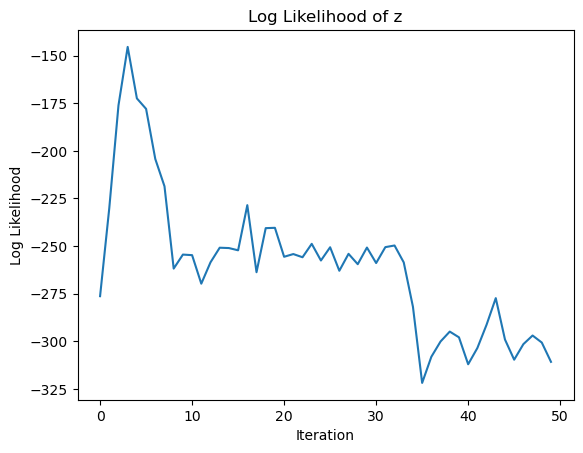

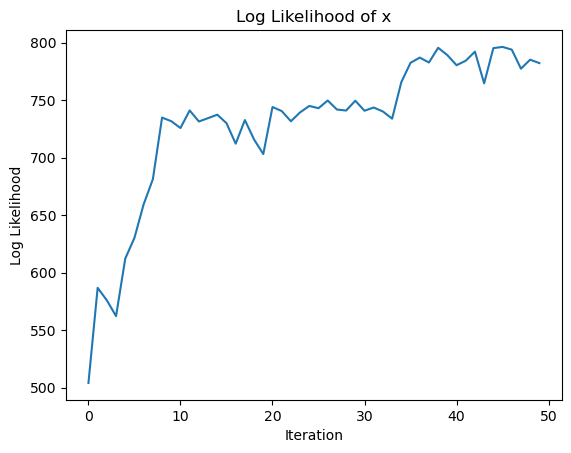

In [34]:
for k, v in ll_history.items():
    plot_ll(k, v)